Compare with Simbad.  
gully

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 

### Read in the K2c02 data crossmatched with kplr

In [3]:
k2c2_yso_all_info = pd.read_csv('../analysis/K2C02_YSO_kplr_match.csv')

In [4]:
k2c2_yso_all_info.shape

(1658, 29)

In [4]:
k2c2_yso_all_info.columns

Index(['EPIC_ID', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       'logstd', 'logiqr', 'fname', 'input_id', 'id', 'k2_ra', 'k2_dec',
       'twomass', 'ucac', 'tyc', 'hip', 'kp', 'bmag', 'vmag', 'rmag', 'imag',
       'jmag', 'hmag', 'kmag', 'kepflag'],
      dtype='object')

## Astroquery

In [5]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, vstack
from collections import Counter

In [6]:
def add_input_column_to_simbad_result(Sim, input_list, verbose=False):
    """Adds 'INPUT' column to the result of a Simbad query

    The motivation for this function is astroquery GitHub issue #473

    When you submit a batch query, you only get back the successes,
    often with different Simbad default names than the input list.
    This discrepancy hinders downstream Table join operations.

    Example:

        import astroquery.simbad
        input_list = ['M82', 'M31', 'junk-identifier1', 'junk-identifier2',
                      '2MASSJ10463795-7736035','M101']
        result = Simbad.query_objects(input_list)
        print result["MAIN_ID"].data

        ['M  82' 'M  31' 'HD  93828' 'M 101']

        result_fix = add_input_column_to_simbad_result(Simbad, input_list)
        print result_fix["INPUT"].data

        ['M82' 'M31' '2MASSJ10463795-7736035' 'M101']

    Args:
      Sim (SimbadClass): The Simbad class used to make the 
      input_list (list): The same list that was used to perform the query.
      verbose (boolean): Prints counts of successes/failures if True.

    Returns:
      Simbad Table with an additional column "INPUT"

    """
    error_string = Sim.last_parsed_result.error_raw
    fails = []

    if error_string is not None:
        for error in error_string.split("\n"):
            start_loc = error.rfind(":")+2
            fail = error[start_loc:]
            fails.append(fail)

    successes = [s for s in input_list if s not in fails]
    if verbose:
        out_message = "There were {} successful Simbad matches and {} failures."
        print(out_message.format(len(successes), len(fails)))

    Sim.last_parsed_result.table["INPUT"] = successes

    return Sim.last_parsed_result.table

In [7]:
customSimbad = Simbad()
customSimbad.add_votable_fields('otype', 'id', 'sptype', 'flux(V)', 'flux(I)','flux(H)', 'flux(K)')

In [8]:
candidates = ['203516237', '203642381', '203731383', '203793391', '203826403',
       '203801323', '203810698']

In [9]:
#ci = k2c2_yso_all_info.EPIC_ID.astype(str).isin(candidates)
ci = k2c2_yso_all_info.twomass != 'None'
k2c2_yso_all_info['sim_2MASS'] = '2MASS J' + k2c2_yso_all_info.twomass
k2c2_yso_all_info.sim_2MASS.replace(to_replace='2MASS JNone', value='---', inplace=True)
targ_list = k2c2_yso_all_info.sim_2MASS[ci].values.tolist()

In [10]:
import warnings

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    temp = customSimbad.query_objects(targ_list)
    result = add_input_column_to_simbad_result(customSimbad, targ_list, verbose=True)
    res_df = result.to_pandas()

There were 923 successful Simbad matches and 719 failures.


In [12]:
res_df.columns

Index(['MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH',
       'COO_BIBCODE', 'OTYPE', 'ID', 'SP_TYPE', 'SP_QUAL', 'SP_BIBCODE',
       'FLUX_V', 'FLUX_I', 'FLUX_H', 'FLUX_K', 'INPUT'],
      dtype='object')

In [13]:
res_df.shape

(923, 21)

## Merge the dataframes

In [16]:
k2c2_yso_all_info.columns

Index(['EPIC_ID', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       'logstd', 'logiqr', 'fname', 'input_id', 'id', 'k2_ra', 'k2_dec',
       'twomass', 'ucac', 'tyc', 'hip', 'kp', 'bmag', 'vmag', 'rmag', 'imag',
       'jmag', 'hmag', 'kmag', 'kepflag', 'sim_2MASS'],
      dtype='object')

In [17]:
k2_simbad = pd.merge(k2c2_yso_all_info, res_df, how = 'outer', left_on='sim_2MASS', right_on='INPUT')

In [29]:
k2_simbad.columns

Index(['EPIC_ID', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       'logstd', 'logiqr', 'fname', 'input_id', 'id', 'k2_ra', 'k2_dec',
       'twomass', 'ucac', 'tyc', 'hip', 'kp', 'bmag', 'vmag', 'rmag', 'imag',
       'jmag', 'hmag', 'kmag', 'kepflag', 'sim_2MASS', 'MAIN_ID', 'RA', 'DEC',
       'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE',
       'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'OTYPE', 'ID', 'SP_TYPE',
       'SP_QUAL', 'SP_BIBCODE', 'FLUX_V', 'FLUX_I', 'FLUX_H', 'FLUX_K',
       'INPUT'],
      dtype='object')

Save the merged dataframe to the `analysis` directory.

In [70]:
k2_simbad['OTYPE']=k2_simbad.OTYPE.str.decode('utf-8')

In [71]:
k2_simbad.to_csv('../analysis/K2C02_YSO_simbad_match.csv', index=False)

### Plot fun with seaborn

We'll need a *control sample*, which we define as anything that was not proposed for specifically as an OPH/SCO target.

In [28]:
control = pd.read_csv('../analysis/K2C02_control_agg_data.csv')
cdf = control

In [21]:
tdf = k2_simbad[['EPIC_ID', 'sim_2MASS', 'MAIN_ID', 'logstd', 'logiqr', 'bmag', 'vmag', 'rmag', 'imag',
       'jmag', 'hmag', 'kmag', 'OTYPE', 'SP_TYPE', 'FLUX_V', 'FLUX_I', 'FLUX_H', 'FLUX_K'] ]

Does the `kplr` $H$ band mag match up with `Simbad` $H$ band mag?

In [22]:
#sns.lmplot('hmag', 'FLUX_H', data=tdf, line_kws={'alpha':0.3, 'color':'#EF0E03'})
#sns.lmplot('kmag', 'FLUX_K', data=tdf, line_kws={'alpha':0.3, 'color':'#EF0E03'})

Yes, they match up very well.  Good sanity check!

We need a new column to simply the object types.

In [23]:
tdf.SP_TYPE.unique()

array([nan, b'F3V', b'G8IV(e)', b'K1III:', b'', b'G8IV', b'A0', b'A0V',
       b'K0IV(e)', b'G0V', b'K1V(e)', b'A6IV', b'M6', b'F5V', b'A3V',
       b'G2IV', b'M5.5', b'A1V', b'K7Ve', b'K5e', b'F6V', b'K0/K1III:',
       b'F5', b'G9V(e)', b'M2', b'B9V', b'K7', b'M0', b'F2V', b'F9V',
       b'A9V+...', b'B8II', b'G1', b'M1', b'A5IV', b'G8V', b'M5',
       b'A2m...', b'M3.5', b'M5-6', b'K5V(e)', b'B5III', b'K5', b'M4.5',
       b'B8V', b'A2V', b'M4.75', b'M3', b'K3', b'K0', b'F4V', b'M3.75',
       b'Me', b'G5', b'M4', b'G4', b'K6', b'K2', b'K1', b'K3/M0e', b'B5V',
       b'M4.25', b'A5IV/V', b'M6.5', b'K8', b'K4/M2.5e', b'K4', b'F7V',
       b'M2.5', b'M6.0', b'M5.25', b'M8', b'K3:', b'K9', b'M4III', b'M8.5',
       b'M7.5', b'G9', b'M5III', b'M7', b'B7Vv...', b'M2III', b'M2e',
       b'B2III/IV', b'M0.5', b'G9V', b'M6.25', b'A7', b'B6IV', b'M3.25',
       b'G7', b'B4', b'K0:', b'G0', b'A1III/IV', b'K0e', b'K0:Ve',
       b'B9IIv...', b'G3', b'F2', b'M4.25IIIC', b'G3.5', b'M4.5III',
   

We have to ignore the omnipresent "set dataframe copy warning".

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tdf['Spectral Type'] = 'Other'

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tdf['Spectral Type'][tdf.SP_TYPE != tdf.SP_TYPE] = 'Unknown'
    tdf['Spectral Type'][tdf.SP_TYPE.str.contains(b'K') == True] = 'K'
    tdf['Spectral Type'][tdf.SP_TYPE.str.contains(b'M') == True] = 'M'

In [26]:
tdf['Spectral Type'].unique()

array(['Unknown', 'Other', 'K', 'M'], dtype=object)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


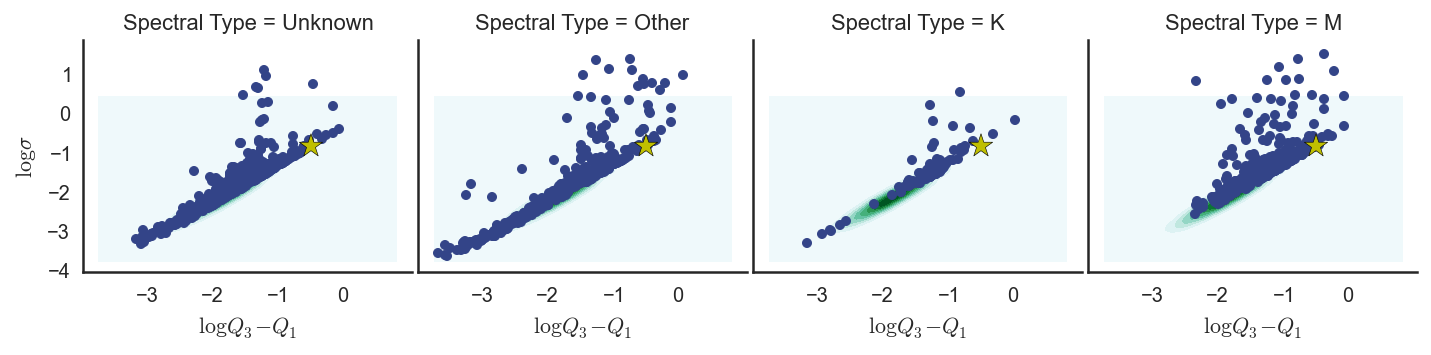

In [30]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tdf, col="Spectral Type", margin_titles=True, size=2.5)
for i in range(4):
    this_ax = g.facet_axis(0, i)
    sns.kdeplot(cdf.logiqr, cdf.logstd, shade=True, ax=this_ax)
g.map(plt.scatter, "logiqr", "logstd", color="#334488", edgecolor="white", lw=.5);
g.set_axis_labels("$\log{Q_3-Q_1}$", "$\log{\sigma}$");
g.set(xticks=[-4, -3, -2, -1, 0], yticks=[-4, -3, -2, -1, 0, 1, 2]);
g.fig.subplots_adjust(wspace=.02, hspace=.02);
for i in range(4):
    this_ax = g.facet_axis(0, i)
    this_ax.scatter([-0.489], [-0.787], s=150, marker='*', c='y')

In [31]:
tdf.OTYPE.unique()

array([nan, b'Star', b'RotV*', b'Candidate_YSO', b'X', b'TTau*', b'pMS*',
       b'*inAssoc', b'brownD*', b'**', b'RGB*', b'PulsV*delSct', b'*inCl',
       b'Orion_V*', b'Ae*', b'Em*', b'IR', b'Flare*', b'YSO', b'AGB*',
       b'Candidate_brownD*', b'Candidate_TTau*', b'RotV*alf2CVn', b'BYDra',
       b'V*', b'RSCVn', b'EB*Algol', b'Cepheid', b'SB*'], dtype=object)

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tdf['Object Type'] = 'Other'

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tdf['Object Type'][tdf.OTYPE != tdf.OTYPE] = 'Unknown'
    
    yso = ((tdf.OTYPE == b'TTau*') | (tdf.OTYPE == b'pMS*') | (tdf.OTYPE == b'*inAssoc') |
           (tdf.OTYPE == b'*inCl') | (tdf.OTYPE == b'Ae*') | (tdf.OTYPE == b'YSO') )
           
    var_star = ((tdf.OTYPE == b'V*') | (tdf.OTYPE == b'RotV*') |
                (tdf.OTYPE == b'Orion_V*') | (tdf.OTYPE == b'PulsV*delSct') |
                (tdf.OTYPE == b'RSCVn') | (tdf.OTYPE == b'EB*Algol') |
                (tdf.OTYPE == b'Cepheid') | (tdf.OTYPE == b'RotV*alf2CVn') )
    
    tdf['Object Type'][yso] = 'Young Star'
    tdf['Object Type'][var_star] = 'Variable Star'
    #tdf['Object Type'][tdf.OTYPE == b'Flare*'] = 'Flare Star'
    
    #tdf['Object Type'][tdf.OTYPE == b'TTau*'] = 'T-Tauri Star'
    #tdf['Object Type'][tdf.OTYPE.str.contains(b'RSCVn') == True] = 'RS CVn Variable'                
    #tdf['Object Type'][] = 'Variable Star'

In [34]:
tdf['Object Type'].unique()

array(['Unknown', 'Other', 'Variable Star', 'Young Star'], dtype=object)

### Overplot the control sample!

In [35]:
sns.set(color_codes=True)

In [36]:
cmap_blue = sns.light_palette("blue", as_cmap=True)
pal_blue = sns.light_palette("blue")
cmap_red = sns.light_palette("red", as_cmap=True)
pal_red = sns.light_palette("red")

In [53]:
sns.set_context('talk', font_scale=1.3)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


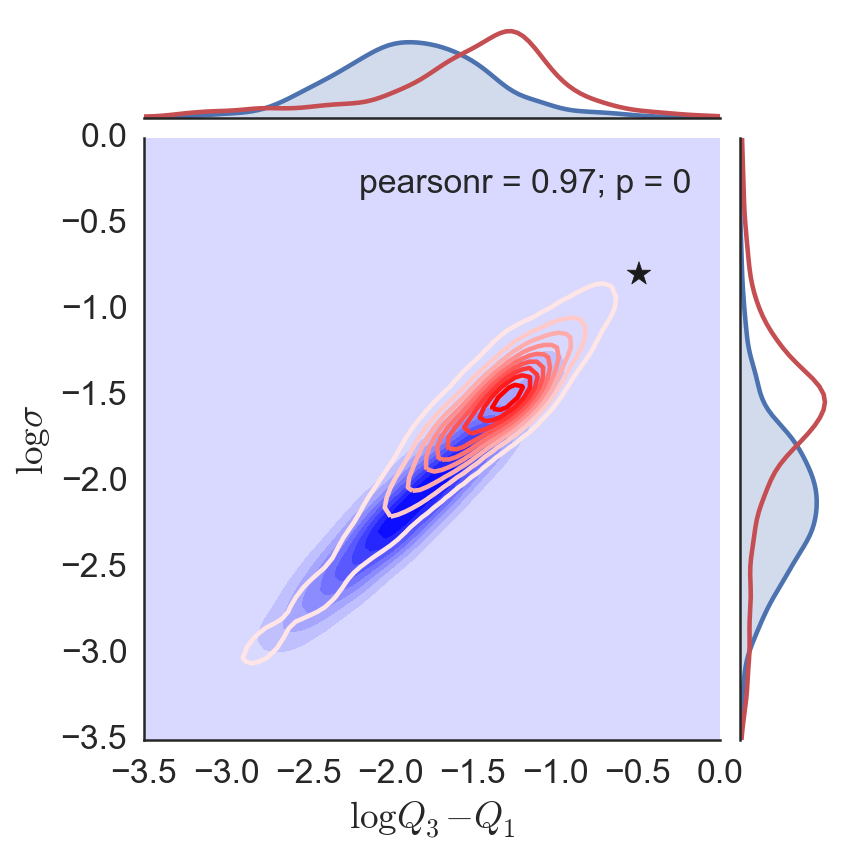

In [55]:
with sns.axes_style("white"):
    tp = sns.jointplot('logiqr', 'logstd', data=cdf, kind='kde', cmap=cmap_blue,
                       xlim=(-3.5, 0), ylim=(-3.5, 0), )
    sns.kdeplot(tdf.logiqr, tdf.logstd, shade=False, ax=tp.ax_joint, cmap=cmap_red, shade_lowest=False)
    sns.distplot(tdf.logiqr, hist=False, ax=tp.ax_marg_x, color='r');
    tp.ax_marg_x.get_xaxis().set_visible(False)
    tp.ax_marg_y.get_yaxis().set_visible(False)
    sns.distplot(tdf.logstd, hist=False, ax=tp.ax_marg_y, color='r', vertical=True);
    #LkCa4 amplitude from Grankin et al. 2008
    tp.set_axis_labels("$\log{Q_3-Q_1}$", "$\log{\sigma}$");
    tp.ax_joint.scatter([-0.489], [-0.787], s=150, marker='*', c='k')
    
plt.savefig('../talk/figures/K2_YSO_variability_overview.pdf')

In [57]:
sns.set_context('paper', font_scale=1.3)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


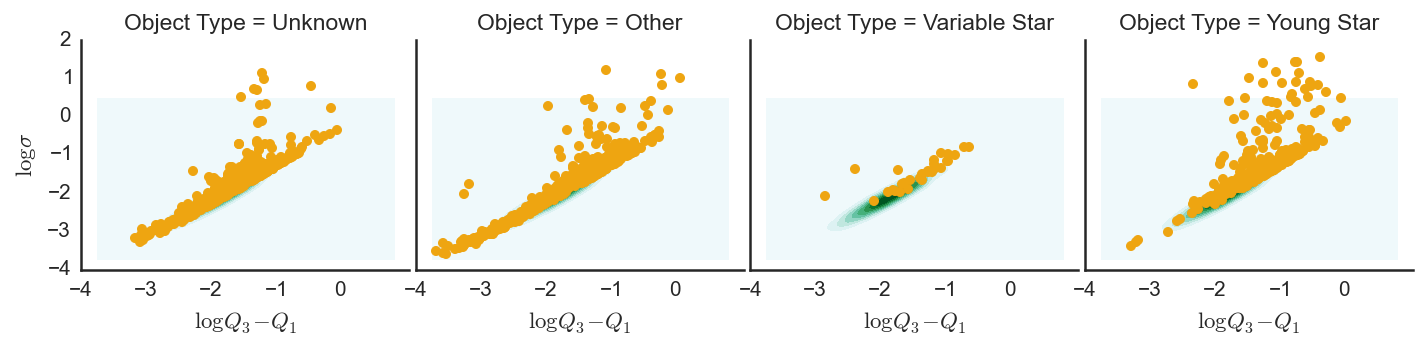

In [60]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tdf, col="Object Type", margin_titles=True, size=2.5)
#g.map(sns.kdeplot, 'logiqr', 'logstd', shade=True)
for i in range(4):
    this_ax = g.facet_axis(0, i)
    #sns.kdeplot(tdf.logiqr, tdf.logstd, shade=False, ax=this_ax)
    sns.kdeplot(cdf.logiqr, cdf.logstd, shade=True, ax=this_ax)
g.map(plt.scatter, "logiqr", "logstd", color="#EEa511", edgecolor="white", lw=.5);

g.set_axis_labels("$\log{Q_3-Q_1}$", "$\log{\sigma}$");
g.set(xticks=[-4, -3, -2, -1, 0], yticks=[-4, -3, -2, -1, 0, 1, 2]);
g.fig.subplots_adjust(wspace=.02, hspace=.02);
plt.savefig('../talk/figures/K2_YSO_variability_Otype.pdf')

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


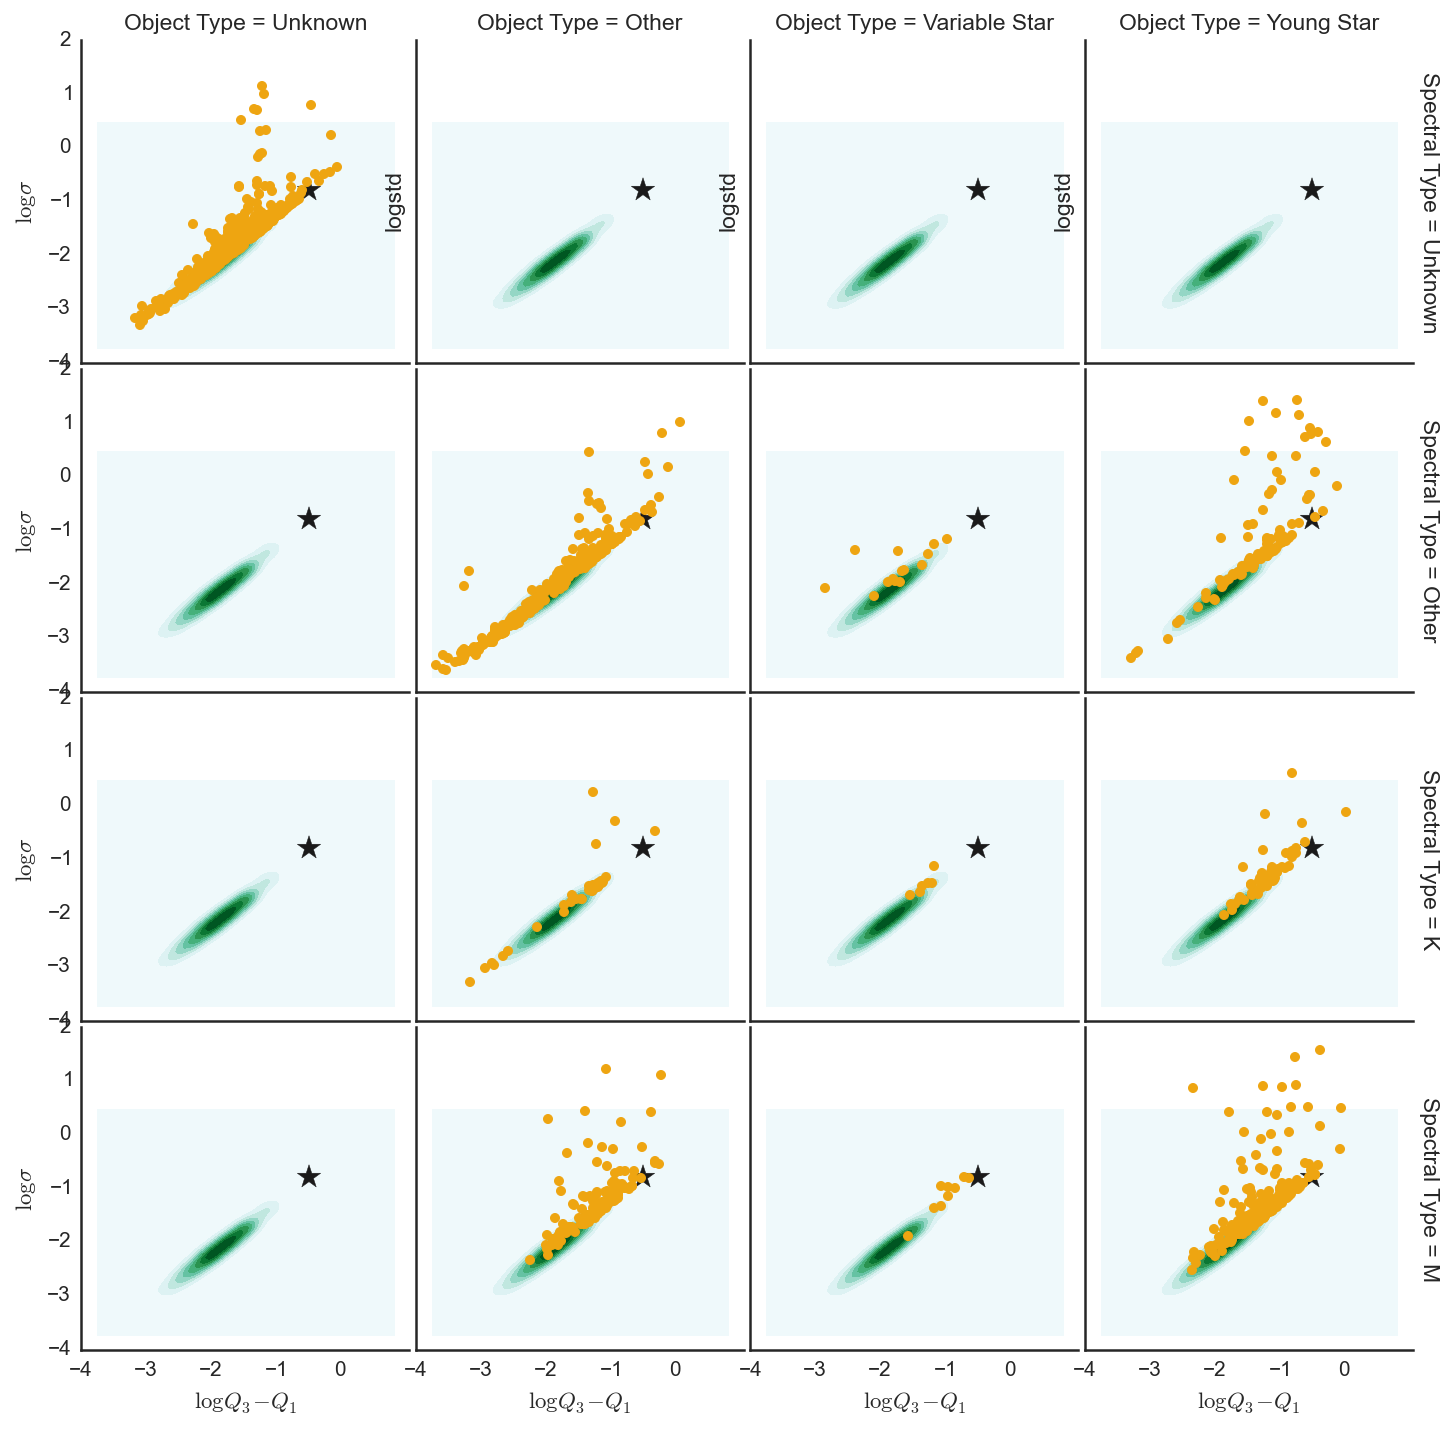

In [61]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tdf, row='Spectral Type', col="Object Type", margin_titles=True, size=2.5)
for j in range(4):
    for i in range(4):
        this_ax = g.facet_axis(i, j)
        sns.kdeplot(cdf.logiqr, cdf.logstd, shade=True, ax=this_ax)
        this_ax.scatter([-0.489], [-0.787], s=150, marker='*', c='k')
g.map(plt.scatter, "logiqr", "logstd", color="#EEa511", edgecolor="white", lw=.5);

g.set_axis_labels("$\log{Q_3-Q_1}$", "$\log{\sigma}$");
g.set(xticks=[-4, -3, -2, -1, 0], yticks=[-4, -3, -2, -1, 0, 1, 2]);
g.fig.subplots_adjust(wspace=.02, hspace=.02);
plt.savefig('../talk/figures/K2_YSO_variability_spec_and_Otype.pdf')

Awesome!

In [62]:
tdf['Object Type'].unique()

array(['Unknown', 'Other', 'Variable Star', 'Young Star'], dtype=object)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


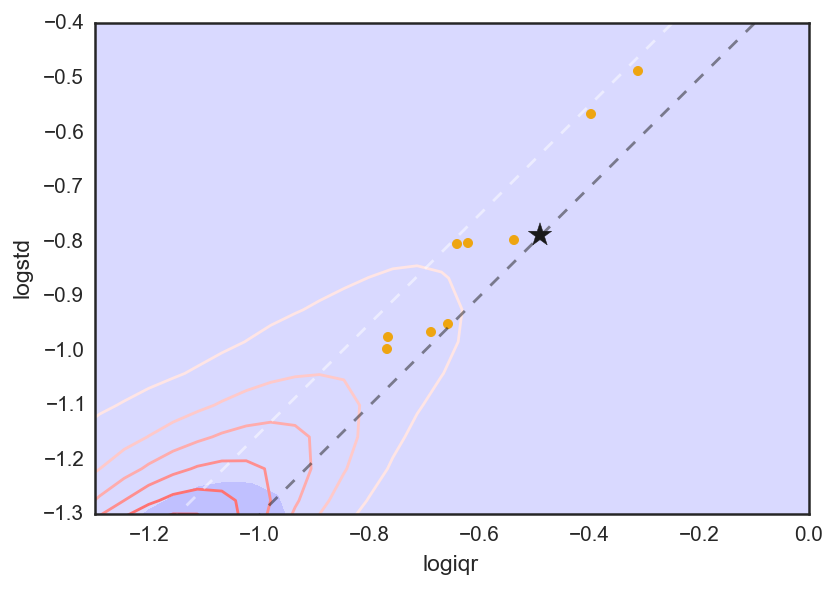

In [64]:
cands = ((tdf['logiqr'] > -0.8) &
      (tdf['logiqr'] < -0.3) &
      (tdf['logstd'] < (tdf.logiqr + np.log10(0.50) +0.15)) &
      (tdf['Spectral Type'] == 'M') &
      (tdf.hmag < 11.0) &
      (tdf.kmag < 11.0) )


with sns.axes_style("white"):
    sns.kdeplot(cdf.logiqr, cdf.logstd, shade=True, cmap=cmap_blue)
    sns.kdeplot(tdf.logiqr, tdf.logstd, shade=False, cmap=cmap_red)
    plt.scatter([-0.489], [-0.787], s=150, marker='*', c='k')
    plt.scatter(tdf.logiqr[cands], tdf.logstd[cands], color="#EEa511", edgecolor="white", lw=.5);
    plt.xlim(-1.3, 0)
    plt.ylim(-1.3, -0.4)
    
    math_x = np.linspace(-4, 0.5, num=50)
    math_y = math_x + np.log10(0.50)
    plt.plot(math_x, math_y, 'k--', alpha=0.5)
    plt.plot(math_x, math_y+0.15, 'w--', alpha=0.5)
    
#g.set_axis_labels("$\log{Q_3-Q_1}$", "$\log{\sigma}$");
#g.set(xticks=[-4, -3, -2, -1, 0], yticks=[-4, -3, -2, -1, 0, 1, 2]);
#g.fig.subplots_adjust(wspace=.02, hspace=.02);

The end.